# Analyzing the House Expenditures Dataset

The House Expenditures dataset published by ProPublica contains detailed expense records of every representative and office in the House from 2009Q3 to 2018Q1. After examining time trends and common spending categories over this period, I hone in on compensation records to analyze Congressional staff salaries. I then use the results of my analysis on the determinants of staff salaries to build a linear regression model that predicts the salary given a particular representative and a job title. 

In [2]:
import pandas as pd
import numpy as np 
import os
%matplotlib notebook 
import matplotlib.pyplot as plt 
os.chdir("C:\\Users\\Sanata\\Dropbox\\01A_Data Science Project")
pd.options.display.max_rows = 25

#import dataset 
df = pd.read_pickle('C:\\Users\\Sanata\\Dropbox\\01A_Data Science Project\\house-office-expenditures-with-readme\\congress_spending')


I analyze two datasets. The first, imported above, comes from appending the quarterly expense reports downloaded from ProPublica's website (script is available in another notebook). The second, which will be read in further below, is a dataset on House Member characteristics created from ProPublica's Congress API (script also available).  

## Part 1: Overview of Expenditures Data 

In this first section, I examine broad trends in Congress spending. My measures are annual, so I subset the data to full years observed, 2010-2017.

A first look at total spending over time illustrates an important point about the quality of expense recordkeeping in the House. the left graph suggests that total expenditures tripled in 2017, jumped from an average of 1.25 billion to 3 billion. But this spike represents the total expenses *reported* in a given year, not actually undertaken. Graphing the total expenses *initiated* in a given year, we see that total spending has remained steady, and actually dropped somewhat in 2017. The discrepancy occurs because Congress has up to three years to report their expenses. For the remainder of this document, expenses in a given year indicate expenses that were initiated in that year. 

<IPython.core.display.Javascript object>


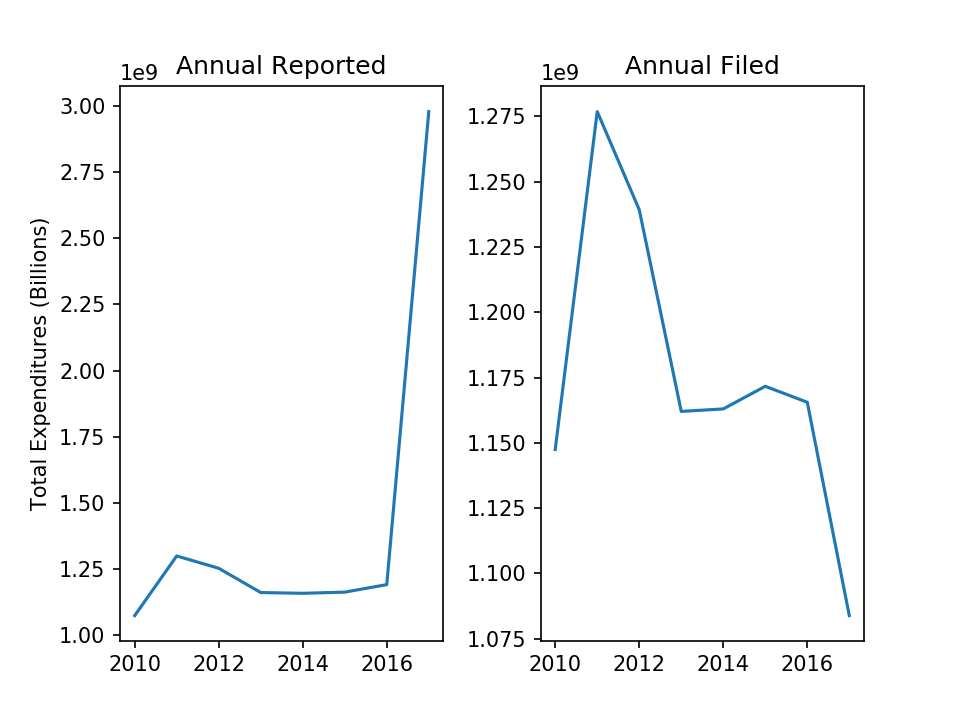

In [85]:
#total spending by year, full years only 
sum_by_yr = df[~df.f_year.isin([2009, 2018])].pivot_table('amount', index='f_year', aggfunc='sum')
#total spending by start year, full years only 
sum_by_start_yr = df[~df.start_yr.isin([2009, 2018])].pivot_table('amount', index='start_yr', aggfunc='sum')

fig, ax = plt.subplots(1, 2)
ax[0].plot(sum_by_yr)
ax[0].set_title('Annual Reported')
ax[1].plot(sum_by_start_yr)
ax[1].set_title('Annual Initiated')
plt.subplots_adjust(wspace=0.3)
ax[0].set_ylabel('Total Expenditures (Billions)')



### 2016 Trends 

I look at trends in categories of spending in a single year, 2016. Personnel compensation and benefits are the largest categories, followed by rent, equipment and materials. 

In [45]:
#spending by category in 2016  
df[df.start_yr==2016].groupby('category')['amount'].sum().sort_values(ascending=False)

category
PERSONNEL COMPENSATION            6.776533e+08
PERSONNEL BENEFITS                2.234522e+08
OTHER SERVICES                    6.828824e+07
EQUIPMENT                         5.230912e+07
RENT, COMMUNICATION, UTILITIES    4.358014e+07
SUPPLIES AND MATERIALS            2.795239e+07
TRAVEL                            2.436483e+07
RENT COMMUNICATION UTILITIES      1.489732e+07
PRINTING AND REPRODUCTION         1.399605e+07
FRANKED MAIL                      1.278747e+07
RENT  COMMUNICATION  UTILITIES    5.608607e+06
BENEFITS TO FORMER PERSONNEL      5.565294e+05
TRANSPORTATION OF THINGS          7.001572e+04
INSURANCE CLAIMS & INDEMNITIES    9.219640e+03
Name: amount, dtype: float64

The office with the highest expenditures in Congress is Government Contributions. We see that it's the highest because the office is responsible for distributing Congressional members' retirement benefits (FERS) and health insurance. The Contributions Office accounts for almost 20% of total spending in 2016. 

In [300]:
#spending by office in 2016 
sub = df[df.start_yr==2016]
by_office = sub.groupby('office')['amount'].sum().sort_values(ascending=False)
by_office[:10]

office
GOVERNMENT CONTRIBUTIONS          2.187423e+08
CHIEF ADMIN OFCR OF THE HOUSE     1.286836e+08
COMMITTEE ON APPROPRIATIONS       2.537312e+07
CLERK OF THE HOUSE                2.323873e+07
SERGEANT AT ARMS                  1.132656e+07
COMMITTEE ON ENERGY & COMMERCE    1.128066e+07
LEGISLATIVE COUNSEL               8.666632e+06
COMM ON OVRSIGHT & GOVT REFORM    8.591573e+06
JOINT COMMMITTEE ON TAXATION      8.581007e+06
COMMITTEE ON WAYS AND MEANS       8.480027e+06
Name: amount, dtype: float64

In [49]:
#for top office, find purpose with highest cost 
gov_cont_purpose = sub[sub.office=='GOVERNMENT CONTRIBUTIONS'].groupby('purpose')['amount'].sum().sort_values(ascending=False)
#top 10 purposes 
gov_cont_purpose[:10]
#top is FERS (congressional members' retirement benefits)


purpose
FERS                  81451623.46
HEALTH INSURANCE      26565188.31
FICA                  19484109.36
TSP MATCHING          18990627.89
FURTHER FERS RAE      15209000.68
STUDENT LOANS         14669207.67
HEALTH INSURANCE F    12276523.43
HEALTH INSURANCE A     7571033.79
FERS RAE               6640937.37
TSP BASIC              6573747.37
Name: amount, dtype: float64

In [309]:
pct_gov = by_office.iloc[0] / sub.amount.sum()
print('The Office of {0} accounts for {1:.1%} of all 2016 expenses.'.format(by_office.index.values[0].title(), pct_gov))

The Office of Government Contributions accounts for 18.8% of all 2016 expenses.


The most common purpose category for expenditures was student loans, which makes sense given the number of Congressional staffers likely to have student loan debt. 

In [50]:
#most common purpose with start date in 2016 
tab = sub.purpose.value_counts().sort_values(ascending=False)
tab[:10]


STUDENT LOANS                     28444
PRIVATE AUTO MILEAGE              27845
OFFICE SUPPLIES (OUTSIDE)         21849
TELECOMSRV/EQ/TOLL CHARGE         17115
TAXI/PARKING/TOLLS                16994
COMMERCIAL TRANSPORTATION         16110
UTILITIES                         13147
FOOD & BEVERAGE                   12919
POSTAGE / COURIER / BOX RENTAL    12587
MEALS                             10856
Name: purpose, dtype: int64

Out of a total of 10 spending categories, the travel was the most commonly cited in 2016. 

In [51]:
#most common category with start date in 2016 
tab = sub.category.value_counts().sort_values(ascending=False)
tab[:10]
#most common is travel 

TRAVEL                            88792
SUPPLIES AND MATERIALS            70551
RENT, COMMUNICATION, UTILITIES    56835
PERSONNEL COMPENSATION            56808
PERSONNEL BENEFITS                30587
OTHER SERVICES                    20059
RENT COMMUNICATION UTILITIES      19660
PRINTING AND REPRODUCTION         13758
EQUIPMENT                         12666
FRANKED MAIL                      10780
Name: category, dtype: int64

### Merging spending and House Members data 

How does spending vary by House member characteristics, especially by party? To answer this question, I first merge the spending data to House member data on party, seniority, gender, etc. 

In [ ]:
df['cong_num'] = None 

In [ ]:
#add congress session number to merge on 
df.loc[df.start_yr.isin([2009, 2010]),'cong_num'] = 111
df.loc[df.start_yr.isin([2011, 2012]),'cong_num'] = 112
df.loc[df.start_yr.isin([2013, 2014]),'cong_num'] = 113
df.loc[df.start_yr.isin([2015, 2016]),'cong_num'] = 114
df.loc[df.start_yr.isin([2017, 2018]),'cong_num'] = 115

#alternative
#df['cong_num'] = df['start_yr'].map({2009: 111, 2010: 111, 2011: 112})

In [ ]:
df.cong_num.value_counts()

In [ ]:
#read member data  
members = pd.read_pickle('C:\\Users\\Sanata\\Dropbox\\01A_Data Science Project\\congress_members_pickle')
members = members[members.cong_num.isin(list(range(111, 115)))]
#select member variables to keep 
vars_to_keep = ['cong_num', 'id',  'gender', 'votes_with_party_pct', 
                'dw_nominate', 'party', 'seniority', 'leadership_role', 
                'leadership_bin', 'state', 'first_name', 'last_name', 'age']
members = (members[vars_to_keep]
                .rename(index=str, columns={"id": "bioguide_id"}) #rename id variable for merge 
          )

In [ ]:
#merge spending and member data 
df = df.merge(members, on = ['bioguide_id', 'cong_num'], how='left')


In [363]:
#pd.to_pickle(df, 'cong_spending_members_merged')

### Spending by Party 

Now I can ask, for example, what percentage of the expenditures of the top 20 spenders in 2016 come from members of the Democratic Party? It turns out spending levels are pretty evenly split between the two parties. However, the top spender, Rep Mike Kelly (R), outspent the number 2 spender by over 50 percent. 

In [310]:
#Select 2016 start date, and only representatives (i.e. observations with a Bioguide ID)
spend16 = df[(df.start_yr==2016) & (df.bioguide_id.notnull())]
#calculate sums by representative 
spend_by_rep = pd.DataFrame( spend16.groupby('bioguide_id')['amount'].sum().sort_values(ascending=False).reset_index()) 
#add party and name of representative 
final = (spend_by_rep
           .join(spend16[['bioguide_id', 'party', 'office']].set_index('bioguide_id'), on = 'bioguide_id')
           .drop_duplicates('bioguide_id')
           .dropna(subset=['party'])
       )
final[:20]

,bioguide_id,amount,party,office
0,K000376,2455545.58,R,HON. MIKE KELLY
2,C001103,1613596.24,R,HON. EARL L. BUDDY CARTER
3,M000087,1409965.17,D,HON. CAROLYN B. MALONEY
4,Z000018,1360360.16,R,HON. RYAN K. ZINKE
5,L000582,1357517.48,D,HON. TED LIEU
6,C001049,1343129.49,D,HON. WILLIAM LACY CLAY
7,N000002,1340387.65,D,HON. JERROLD NADLER
8,P000611,1338873.00,R,HON. BRUCE POLIQUIN
9,L000578,1338552.55,R,HON. DOUG LAMALFA
10,M001197,1338452.13,R,HON. MARTHA MCSALLY


In [313]:
ans = (final[:20].party=='D').mean()
print('{0:.0%} of the top 20 spenders in 2016 came from the Democratic party'.format(ans))
print('{0} was the top spender in the House in 2016'.format(final.office.iloc[0].title()))

50% of the top 20 spenders in 2016 came from the Democratic party
Hon. Mike Kelly was the top spender in the House in 2016


In [312]:
final.groupby('party')['amount'].mean()

party
D    1.218182e+06
R    1.194278e+06
Name: amount, dtype: float64

## Turnover Rates

Next I calculate the staff turnover rate by year, from 2010-2016, to see how well Representatives hold on to their staff. Turnover in a given year is calculated as the fraction of a representative's staff from last year who did not carry over to this year. I only considered representatives who served for at least 4 years and had staff size of at least 5 every year that they served.

In [417]:
#clean payees
df['payee2'] = df['payee']
df.loc[:, 'payee'] = df.payee2.str.replace('[\s,.-]', '')

In [314]:
#create subset 
sub = df.loc[(df.f_year >= 2010) &   #time range 
             (df.f_year <= 2016) & 
             (df.bioguide_id.notnull()) &  #reps only 
             (df.category=='PERSONNEL COMPENSATION')] #employees only
sub.shape 

(302179, 35)

In [315]:
#have at least 5 payees every year 
staff_sizes = sub.groupby(['bioguide_id', 'f_year'])['payee'].size().reset_index(level=1)
reps_to_keep = np.unique( staff_sizes[staff_sizes>=5].index.values )
sub = sub[sub.bioguide_id.isin(reps_to_keep)]

In [316]:
#have 4 or more years of tenure 
reps_num_yrs = staff_sizes.groupby('bioguide_id').size()
reps_to_keep = reps_num_yrs[reps_num_yrs>=4].index.values 
reps_to_keep.shape
sub = sub[sub.bioguide_id.isin(reps_to_keep)]
sub.shape 

(271746, 35)

In [318]:
#reduce dataset to observations by employees instead of representatives 
emps = (sub.groupby(['bioguide_id', 'f_year', 'payee'])['payee']
              .size()
              .rename('n_years', inplace=True)
              .reset_index())
emps.shape 
print('There are {} unique employees in the dataset'.format(emps.shape[0]))

There are 74950 unique employees in the dataset


In [319]:
#get turnover rate for one rep, one year 
def get_turnover(year, year_minus_one, repid):
    """
    Returns a single turnover rate  
    """
    staff_previous = emps.loc[(emps.bioguide_id==repid) & (emps.f_year==year_minus_one)]['payee']
    staff_current = emps.loc[(emps.bioguide_id==repid) & (emps.f_year==year)]['payee']
    if (len(staff_previous)==0) | (len(staff_current)==0):
        return None 
    return (staff_previous.isin(staff_current)==False).sum() / len(staff_previous)

#get turnover rate for all reps, one year 
def get_all_turnover(year, year_minus_one, srs_of_reps): 
    """
    Returns a series of turnover rates 
    """
    return srs_of_reps.apply(lambda x: get_turnover(year, year_minus_one, x))


In [320]:
#testing the functions above: 
year = 2011
year_minus_one=2010
srs_of_reps = emps.loc[emps.f_year==year, 'bioguide_id'].drop_duplicates() #get unique reps 
m = get_all_turnover(year, year_minus_one, srs_of_reps).median()
print('The median staff turnover rate in 2011 was {0:.0%}'.format(m))


The median staff turnover rate in 2011 was 23%


In [349]:
#get turnover rates for all years, all reps 
#save results in a dictionary with years as keys, and a series of rep turnover rates as values 
all_rates = {}
for i in range(2011, 2017):
    l = get_all_turnover(i, i-1, emps.loc[emps.f_year==i, 'bioguide_id'].drop_duplicates())
    ids = emps.loc[emps.f_year==i, 'bioguide_id'].drop_duplicates()
    l.index = list(ids)
    all_rates[i] = l  
 


In [361]:
#median turnover rate by year 
med_rate_yr = {k: v.median() for k, v in all_rates.items()}
#mean turnover rate by year 
avg_rate_yr = {k: v.mean() for k, v in all_rates.items()}
#stats for whole period 
pd.concat(all_rates.values()).describe()

count    2412.000000
mean        0.266044
std         0.117932
min         0.000000
25%         0.190476
50%         0.259259
75%         0.333333
max         1.000000
Name: bioguide_id, dtype: float64

In [362]:
#add turnover rates to dataset 
dat = (pd.DataFrame(all_rates)   
        .stack()
        .reset_index()
      )
dat.columns = ['bioguide_id', 'start_yr', 'turnover_rate']
dat.head()


,bioguide_id,start_yr,turnover_rate
0,A000022,2011,0.210526
1,A000022,2012,0.173913
2,A000022,2013,0.263158
3,A000055,2011,0.411765
4,A000055,2012,0.595745


In [359]:
df = df.merge(dat, on = ['bioguide_id', 'start_yr'], how='left')

count    1.599321e+06
mean     2.652779e-01
std      1.119201e-01
min      0.000000e+00
25%      1.904762e-01
50%      2.592593e-01
75%      3.333333e-01
max      1.000000e+00
Name: turnover_rate, dtype: float64

#### Plotting turnover rates by year 

The graph below shows a clear pattern in turnover rates: they peak in even (election) years and dip in non-election years, indicating that representatives are likely to renew at least some of their staff every two years. The turnover rate has also been rising on overage over this periood, from an overage of 0.24 to about 0.28 2011-2016. 

<IPython.core.display.Javascript object>


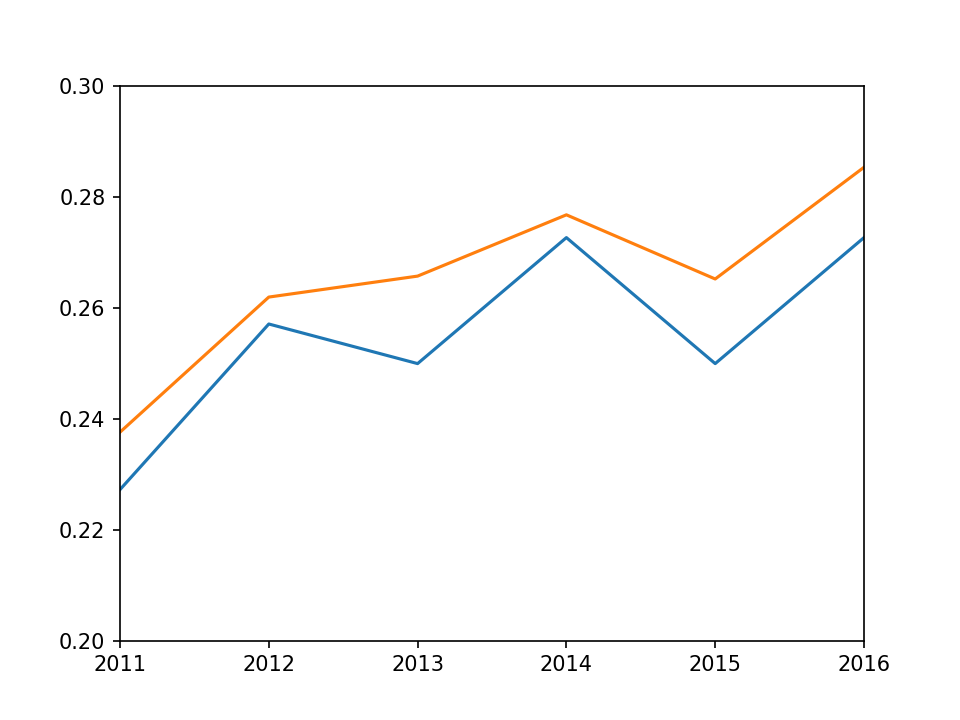

(0.2, 0.3)

In [365]:
fig = plt.figure()
pd.Series(med_rate_yr).plot()
pd.Series(avg_rate_yr).plot()
plt.ylim(0.2, 0.3)

## Part 2: Staff Salaries

I now explore some of the determinants of staff salaries in order to draw insights that will guide my final regression model.   

First I consider staff size by House members and how they vary. 

In [4]:
df = pd.read_pickle('cong_spending_members_merged')

In [5]:
#subset to just representatives in 2016  
sub = df.loc[(df.bioguide_id.notnull()) & (df.start_yr==2016) & (df.category=='PERSONNEL COMPENSATION')]


In [6]:
#staff size by rep 
staff_sizes = pd.DataFrame(
                (sub
                    .groupby('bioguide_id')['payee']
                    .size()
                    .sort_values(ascending=False) 
                     .rename('n_staff', inplace=True)   
                     .reset_index()
                    
                ) )


In [7]:
staff_sizes.head()

,bioguide_id,n_staff
0,K000376,205
1,J000289,160
2,L000563,143
3,D000096,134
4,P000523,133


In [434]:
staff_sizes.describe()

,n_staff
count,444.000000
mean,95.004505
std,16.259464
min,5.000000
25%,86.750000
50%,95.000000
75%,104.000000
max,205.000000


In [393]:
print('The average Representative staff size in 2016 was {0:.0f}.'.format(staff_sizes.n_staff.mean())) 

The average Representative staff size in 2016 was 95


Looking at staff size by Congress member and party, we see that the top 10 are overwhelmingly Democrat. We also see a potential explanation for Rep. Mike Kelly's unusually high expenses: he has a over 200 staff, more than twice the average. 

In [388]:
#add party and name of representative 
staff_sizes = (staff_sizes
               .merge(sub[['bioguide_id', 'party', 'office', 'state']], on='bioguide_id', how='left')
               .drop_duplicates('bioguide_id')
             )             
staff_sizes[:10]

,bioguide_id,payee,party,office,state
0,K000376,205,R,HON. MIKE KELLY,PA
205,J000289,158,R,HON. JIM JORDAN,OH
363,L000563,143,D,HON. DANIEL LIPINSKI,IL
506,B001296,143,D,HON. BRENDAN F. BOYLE,PA
649,M001143,143,D,HON. BETTY MCCOLLUM,MN
792,C000984,137,D,HON. ELIJAH E. CUMMINGS,MD
929,P000523,134,D,HON. DAVID E. PRICE,NC
1063,B001271,127,R,HON. DAN BENISHEK,MI
1190,B000287,126,D,HON. XAVIER BECARRA,CA
1316,A000370,126,D,HON. ALMA S. ADAMS,NC


Next, I move on to salaries: who paid the highest average salary in the House in 2016? 

In [443]:
#calculate mean and median salary by rep
def get_stats(group):
    return {'mean': group.mean(), 'median': group.median()}

#get annual employee salaries 
payee_by_rep = sub.groupby(['bioguide_id', 'payee'])['amount'].sum().reset_index()
#group by representative
grouped = payee_by_rep.groupby('bioguide_id')['amount']
#calculate mean and median salaries
sal = (grouped.apply(get_stats).unstack()
           .rename(index=str, columns={'mean': 'avg_salary', 'median': 'med_salary'})
           .reset_index()
            #add rep info 
           .merge(sub[['bioguide_id', 'office', 'party', 'seniority']], on='bioguide_id', how='left')
           .drop_duplicates('bioguide_id')
      )
sal.sort_values(by = 'avg_salary', ascending=False)[:10]


,bioguide_id,avg_salary,med_salary,office,party,seniority
22084,L000562,65064.538125,58477.075,HON. STEPHEN F. LYNCH,D,16.0
25586,M001177,63803.740625,58716.670,HON. TOM MCCLINTOCK,R,8.0
31878,R000577,63798.664706,52578.960,HON. TIMOTHY J. RYAN,D,14.0
19914,K000363,60821.655625,53447.285,HON. JOHN KLINE,R,14.0
31125,R000409,59557.911667,47499.960,HON. DANA ROHRABACHER,R,28.0
39957,W000799,58953.703125,54191.115,HON. TIMOTHY J. WALZ,D,10.0
5123,C001037,58175.871667,65749.960,HON. MICHAEL E. CAPUANO,D,18.0
41430,Y000033,57931.135000,50295.830,HON. DON YOUNG,R,44.0
10788,D000625,57576.798824,45583.300,"HON. DANIEL M. DONOVAN, JR.",R,2.0
24129,M000404,57484.402105,56500.040,HON. JIM MCDERMOTT,D,28.0


In [436]:
print('{0} paid the highest average staff salary in 2016, at ${1:,.0f}.'.format(sal.office.iloc[0].title(), sal.avg_salary.iloc[0]))


Hon. Stephen F. Lynch paid the highest average salary in 2016, at $65,065.


On average, representatives paid a mean staff salary of \$40,836 in 2016. Rep. Stephen Lynch's average salary of \$65K was well above the average. Mean staff salaries varied wide, with the middle 50 percent offering between \$36K and \$46K. This suggests that representative characteristics likely matter in determining salaries. More evidence for this comes from looking at the seniority of the top 10 payers above: all but two have been in office for 5 terms or more (one term = two years). 

In [437]:
sal.avg_salary.describe()

count      444.000000
mean     40836.120343
std       8380.131201
min        309.630000
25%      36088.952147
50%      40514.804227
75%      46558.333500
max      65064.538125
Name: avg_salary, dtype: float64

Finally, I look at how average salaries have changed over time (2010-2016). 

In [8]:
sub = df[(df.category=='PERSONNEL COMPENSATION') & 
         ~(df.start_yr.isin([2009, 2017, 2018])) & 
         (df.bioguide_id.notnull())]

In [9]:
#avg salary by rep over time 
annual_payee_by_rep = sub.groupby(['start_yr','bioguide_id', 'payee'])['amount'].sum().reset_index()
annual_avg_pay = annual_payee_by_rep.groupby('start_yr')['amount'].mean()
annual_avg_pay

start_yr
2010.0    35314.226753
2011.0    33379.535683
2012.0    39776.162109
2013.0    34101.788867
2014.0    39343.379360
2015.0    32631.510113
2016.0    23393.365902
Name: amount, dtype: float64

In [13]:
annual_staff_by_rep = sub.groupby(['start_yr','bioguide_id'])['payee'].size().reset_index()
annual_avg_staff = annual_staff_by_rep.groupby('start_yr')['payee'].mean()
annual_avg_staff


start_yr
2010.0     94.443946
2011.0     86.628253
2012.0    100.413870
2013.0     82.792776
2014.0     95.200000
2015.0     80.701195
2016.0     95.004505
Name: payee, dtype: float64

We see that, like turnover, salary and staff size fluctuate around election years rather drastically: there is about \$6K difference in salary and 20 more staff in election years versus non-election years. 

<IPython.core.display.Javascript object>


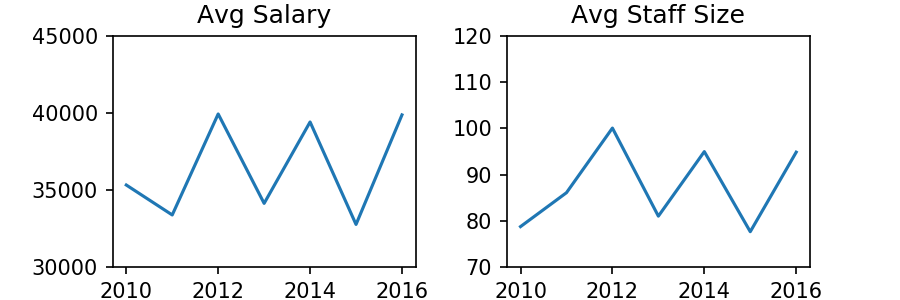

In [461]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2))
ax[0].plot(annual_avg_pay)
ax[0].set_title('Avg Salary')
ax[1].plot(annual_avg_staff)
ax[1].set_title('Avg Staff Size')
ax[0].set_ylim(30000, 45000)
ax[1].set_ylim(70, 120)
plt.subplots_adjust(wspace=0.3)
#plt.figure(figsize=(1,11))


In [17]:
#add staff size variable to dataset 
nstaff = sub.groupby(['start_yr','bioguide_id'])['payee'].size().rename('n_staff').reset_index()
nstaff.head()
df = df.merge(nstaff, on=['start_yr', 'bioguide_id'], how='left')

In [19]:
df.to_pickle('cong_spending_members_merged')

### Employee data 

I look at salary and job title data at the employee and representative levels. 

In [193]:
pd.read_pickle(df, 'cong_spending_members_merged')

In [47]:
#create employee dataset 
sub = df[(df.category=='PERSONNEL COMPENSATION') & 
         (df.bioguide_id.notnull()) & 
         (df.start_yr.isin(list(range(2010, 2017))))]

In [213]:
#pd.to_pickle(sub, 'cong_employee_data') 
#merged congress spending and member data for employee compensation

In [470]:
#unique employees 
sub.payee.value_counts().shape #24K unique employees 

(23959,)

In [49]:
#calculate employee annual pay 
payee_by_rep = (sub
                .groupby(['start_yr', 'bioguide_id', 'payee'])['amount']
                .sum()
                .rename('annual_salary')
                .reset_index()
                )
#add annual pay to the dataset 
sub = sub.merge(payee_by_rep, on = ['start_yr', 'bioguide_id', 'payee'], how='left')

In [517]:
#group annual pay by representative and year 
grouped = sub.groupby(['start_yr','bioguide_id'])['annual_salary']
#calculate mean and median salaries
tab = (grouped.apply(get_stats).unstack()
           .rename(index=str, columns={'mean': 'avg_salary', 'median': 'med_salary'})
           .reset_index()
             #add rep info 
            .merge(sub[['start_yr', 'bioguide_id', 'office', 'party', 'seniority']], on=['bioguide_id'], how='left')
            .drop_duplicates('bioguide_id')
      )
tab.head()

,start_yr_x,bioguide_id,avg_salary,med_salary,start_yr_y,office,party,seniority
0,2010.0,A000014,23487.389508,21849.99,2010,HON. NEIL ABERCROMBIE,D,22.0
61,2010.0,A000022,45042.194767,39250.00,2010,HON. GARY L ACKERMAN,D,28.0
367,2010.0,A000055,35295.335275,38583.35,2010,HON. ROBERT B. ADERHOLT,R,14.0
998,2010.0,A000210,30973.099213,25005.99,2010,HON. ROBERT ANDREWS,D,22.0
1431,2010.0,A000358,46724.811972,52584.15,2010,HON. W. TODD AKIN,R,10.0


<IPython.core.display.Javascript object>


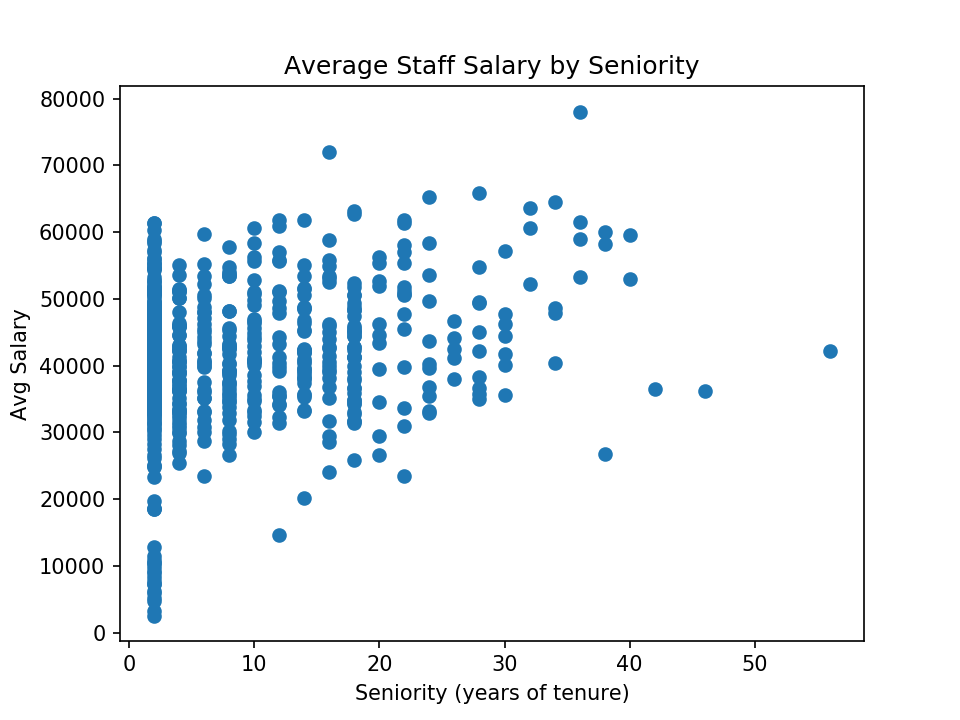

In [518]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(tab.seniority, tab.avg_salary)
ax1.set_title('Average Staff Salary by Seniority')
ax1.set_xlabel('Seniority (years of tenure)')
ax1.set_ylabel('Avg Salary')

Next, I look at how average salaries differ by party: do Democrats or Republicans pay more? 

In [511]:
#average salary by party 
avg_pay_r = sub[sub.party=='R'].groupby(['start_yr'])['annual_salary'].mean()
avg_pay_d = sub[sub.party=='D'].groupby(['start_yr'])['annual_salary'].mean()


<IPython.core.display.Javascript object>


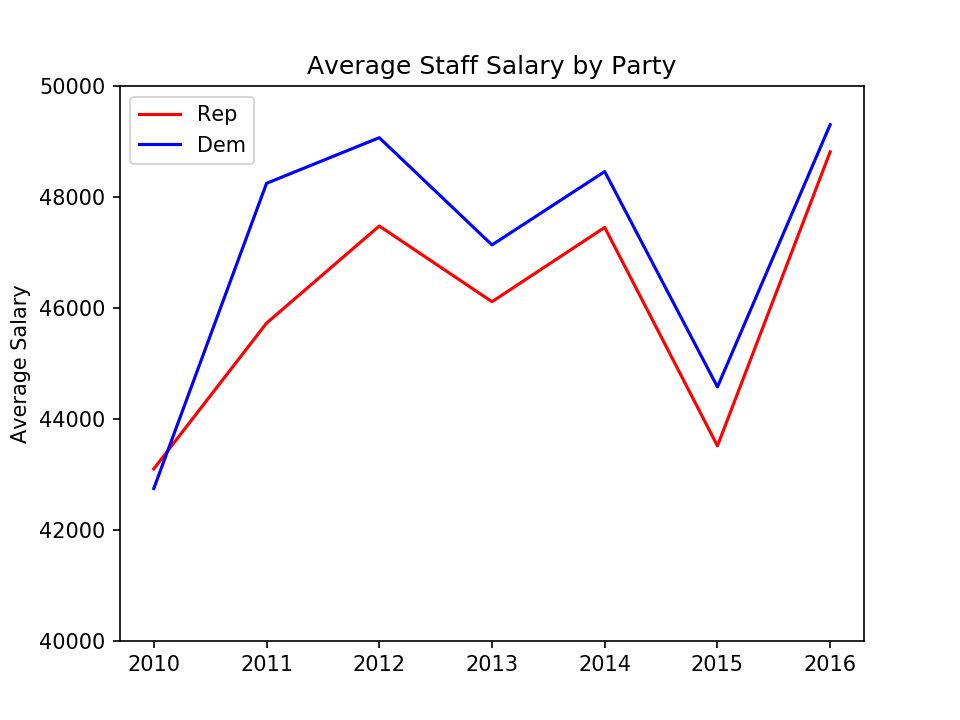

In [513]:
#plot
fig = plt.figure()
plt.plot(avg_pay_r, color='r', label='Rep')
plt.plot(avg_pay_d, color='b', label='Dem')
plt.title('Average Employee Salary by Party')
plt.ylim(40000, 50000)
plt.legend()
plt.ylabel('Average Salary')


Finally, I look at the relationship between staff turnover rates and salary. Below, I plot the average salary for each staff turnover rate observed. We see a negative slope, indicating that offices with high turnover tend to have lower salaries. There is also a clump of outliers at very high turnover rates and very low salaries that would skew the relationship between turnover and salary, making the slope appear to be much steeper than it is. In my final analysis, I omit annual salaries below \$16,000 to address this issue. 

<IPython.core.display.Javascript object>


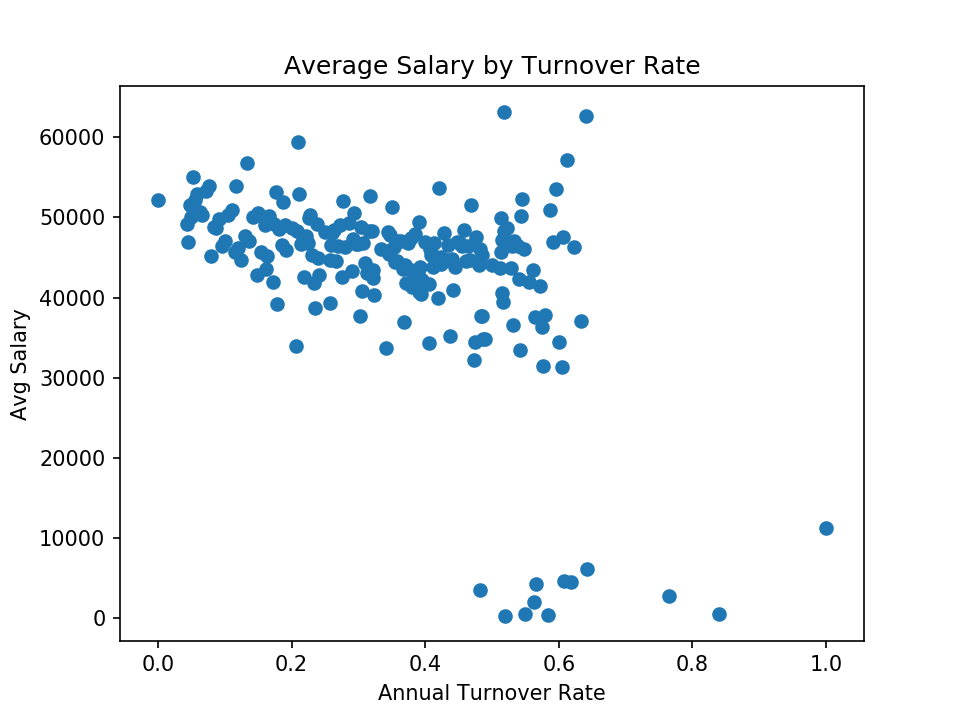

In [529]:
#plot staff turnover rate x staff salary scatter plot 
t = sub.pivot_table('annual_salary', index='turnover_rate', aggfunc='mean')
t = pd.DataFrame(t).reset_index()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(t.turnover_rate, t.annual_salary)
ax1.set_title('Average Salary by Turnover Rate')
ax1.set_xlabel('Annual Turnover Rate')
ax1.set_ylabel('Avg Salary')

# Construct Dataset for Regression

Data cleaning, entity resolution, and pre-processing 

In [ ]:
#Construct dataset

In [259]:
#remove staff making less than 16K/yr (~50K employee observations)  
emps = sub[sub.annual_salary>=16000]
emps.shape

(242107, 38)

In [260]:

#categorize employee job titles (cleaning)
emps['purpose2'] = emps.purpose

emps.loc[:, 'purpose'] = (emps.purpose
                              .str.replace('[^\w\s]', ' ') #remove punctuation 
                              .str.replace(r'(OTHER COMPENSATION)', '')
                              .str.replace('[()]', '')
                              .str.replace('SHARED EMPLOYEE', 'PART TIME EMPLOYEE')
                              .str.replace('PAID INTERN', 'PART TIME EMPLOYEE')
                              .str.replace('TEMPORARY EMPLOYEE', 'PART TIME EMPLOYEE')
                              .str.strip())



C:\Users\Sanata\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Sanata\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [291]:
#Remove part-time and interns 
(emps.purpose=='PART-TIME EMPLOYEE').sum()
emps = emps[emps.purpose != 'PART TIME EMPLOYEE']

In [265]:
#entity resolution 

import itertools
from fuzzywuzzy import fuzz
import re

#remove float 
check_float = emps.purpose.apply(lambda x: isinstance(x, float))
titles_dedup = emps.purpose[~check_float] 

##single word dedup 

m = titles_dedup.drop_duplicates().str.split(' ').tolist()
words = list(itertools.chain.from_iterable(m))
srs = pd.Series(words)

test = srs.apply(lambda x: fuzz.token_sort_ratio('ASSISTANT', x))
srs.loc[test>60].drop_duplicates()
dups = ['ASST', 'ASSIT' ]
regex = re.compile('|'.join(map(re.escape, dups)))
titles_dedup = titles_dedup.apply(lambda x: regex.sub('ASSISTANT', x))

test = srs.apply(lambda x: fuzz.ratio('CONSTITUENT', x))
srs.loc[test>80].drop_duplicates()
dups = ['CONSTITUTENT', 'CONSTTUENT', 'CONSTITIENT', 'CONSITUENT']
regex = re.compile('|'.join(map(re.escape, dups)))
titles_dedup  = titles_dedup.apply(lambda x: regex.sub('CONSTITUENT', x))

test = srs.apply(lambda x: fuzz.ratio('SECRETARY', x))
srs.loc[test>60].drop_duplicates().tolist()
dups = ['SECTY', 'SECY', 'SCTY', 'SECT']
regex = re.compile('|'.join(map(re.escape, dups)))
titles_dedup  = titles_dedup.apply(lambda x: regex.sub('SECRETARY', x))

test = srs.apply(lambda x: fuzz.ratio('LEGISLATIVE', x))
srs.loc[test>60].drop_duplicates().tolist()
dups = ['LEGISLATIIVE', 'LLEGISLATIVE', 'LEGISLTATIVE']
regex = re.compile('|'.join(map(re.escape, dups)))
titles_dedup  = titles_dedup.apply(lambda x: regex.sub('LEGISLATIVE', x))

test = srs.apply(lambda x: fuzz.ratio('CASEWORKER', x))
srs.loc[test>60].drop_duplicates().tolist()
dups = ['CASEWKR', 'CASEWRKER', 'CSWRKR', 'CASEWK', 'CASEWRK' ]
regex = re.compile('|'.join(map(re.escape, dups)))
titles_dedup  = titles_dedup.apply(lambda x: regex.sub('CASEWORKER', x))

test = srs.apply(lambda x: fuzz.ratio('CHIEF', x))
srs.loc[test>50].drop_duplicates().tolist()
dups = [ 'CHF', 'CHEIF']
regex = re.compile('|'.join(map(re.escape, dups)))
titles_dedup  = titles_dedup.apply(lambda x: regex.sub('CHIEF', x))

test = srs.apply(lambda x: fuzz.ratio('SCHEDULER', x))
srs.loc[test>50].drop_duplicates().tolist()
dups = ['SCHDLNG',  'SCHDLR']
regex = re.compile('|'.join(map(re.escape, dups)))
titles_dedup = titles_dedup.apply(lambda x: regex.sub('SCHEDULER', x))


##phrase dedup 

m = titles_dedup.drop_duplicates()

test = m.apply(lambda x: fuzz.token_sort_ratio('COMMUNICATIONS DIRECTOR', x))
m.loc[test>70].drop_duplicates().tolist()
dups = ['DIR OF COMMUNICATION', 'DIRECTOR OF COMMUNICATIONS', 'DIRECTOR COMMUNICATIONS' , 'COMMUNICATION DIR']
regex = re.compile('|'.join(map(re.escape, dups)))
titles_dedup = titles_dedup.apply(lambda x: regex.sub('COMMUNICATIONS DIRECTOR', x))

test = m.apply(lambda x: fuzz.token_sort_ratio('OFFICE MANAGER', x))
m.loc[test>50].drop_duplicates().tolist()
dups = ['OFFICE MGR', 'OFFICE DIRECTOR', 'OFC MANAGER', 'OFFICE MANG', 'OFFICE MNGR', 'OFC MANAGE']
regex = re.compile('|'.join(map(re.escape, dups)))
titles_dedup = titles_dedup.apply(lambda x: regex.sub('OFFICE MANAGER', x))

test = m.apply(lambda x: fuzz.token_sort_ratio('CONSTITUENT SERVICES REP', x))
m.loc[test>60].drop_duplicates().tolist()
dups = ['CONST SVCS REP', 'CONSTITUENT SVCS REP', 'CONSTITUENT SER REP',  'CONST SERV REP', 
        'CONSTITUENT SVC REP', 'CONST SVC FIELD REP', 'CONSTIT SERV REP', 'CONSTITUENT REP', 
        'CONSTITUENT SVS REP', 'CONSTIT SVCS REP' , 'CONSTITUENT SERVICE REP', 'CONSTITUENT SVC REPRESENTATIVE']
regex = re.compile('|'.join(map(re.escape, dups)))
titles_dedup = titles_dedup.apply(lambda x: regex.sub('CONSTITUENT SERVICES REP', x))

#assign to dataframe 
emps.loc[:, 'purpose'] = titles_dedup


In [ ]:
#using info from https://www.everycrsreport.com/reports/RL34545.html,
#https://www.cof.org/content/roles-congressional-staff-members, and https://en.wikipedia.org/wiki/Congressional_staff
#I found the following job categories go together 

#Executive assistant: scheduler
#District director: district chief of staff, District Supervisor
#Constituent Services Representative: Casework Manager, Caseworker
#communications director: press secretary 


In [268]:
#add indicators for job level 

#add director indicator 
director_terms = ['DIR', 'CHIEF', 'COS', 'PRESS SEC']
emps['director_job'] = ((emps.purpose.str.contains('|'.join(director_terms)))==True).astype(int)

#add senior indicator 
senior_terms = ['SENIOR', 'SR']
emps['senior_job'] = ((emps.purpose.str.contains('|'.join(senior_terms)))==True).astype(int)

#add assistant indicator
asst_terms = ['ASSI', 'AIDE']
emps['asst_job'] = emps.purpose.str.contains('|'.join(asst_terms).astype(int)

#add district indicator 
emps['district_job'] = emps.purpose.str.contains('DIST').astype(int)

#revise assistant and director roles 
emps.loc[(emps.director_job==1) & (emps.asst_job==1), 'director_job'] = 0 #remove 'assistant to director' roles 


In [272]:
emps.director_job.value_counts()
emps.senior_job.value_counts()
emps.asst_job.value_counts()
emps.district_job.value_counts()

0    225806
1     10726
Name: senior_job, dtype: int64

In [274]:
#add indicators for job categories 

#on the four substantive categories: 
#https://www.sgim.org/File%20Library/SGIM/Communities/Advocacy/Advocacy%20101/THE-ROLE-OF-CONGRESSIONAL-STAFF.pdf
#http://www.congressfoundation.org/congressional-operations/new-member-resource-center/136-job-descriptions-house-office-sample

#add in policy indicator 
#according to a ProPublica article (https://www.propublica.org/article/turnover-in-the-house-who-keeps-and-who-loses-the-most-staff), 
#the following are policy positions: Legislative Director, Legislative Assistant, Senior Legislative Assistant, 
#Senior Policy Advisor, Policy Advisor, Policy Director, Legislative Counsel, Counsel, Senior Counsel.
policy_terms = ['COUNSEL', 'POLICY', 'LEG' ]
emps['policy_job'] = ((emps.purpose.str.contains('|'.join(policy_terms)))==True).astype(int)


#add admin indicator 
admin_terms = ['STAFF ASSI', 'EXECUTIVE ASSI', 'OFFICE MAN', 'RECEPTION', 'SCHED']
emps['admin_job'] = ((emps.purpose.str.contains('|'.join(admin_terms)))==True).astype(int)


#add field indicator 
field_terms = ['CONSTIT', 'FIELD', 'CASEWORK', 'CASE WORKER']
emps['field_job'] = ((emps.purpose.str.contains('|'.join(field_terms)))==True).astype(int)


In [278]:
emps.policy_job.value_counts()
emps.admin_job.value_counts()
emps.pol_job.value_counts()
emps.field_job.value_counts()

0    174413
1     62119
Name: policy_job, dtype: int64

In [279]:
#add election year indicator 
emps['elect_yr'] = emps.start_yr.isin([2010, 2012, 2014, 2016]).astype(int)

In [294]:
#check % of job titles without a category 
job_vars = ['director_job', 'senior_job', 'asst_job', 'district_job', 
            'policy_job', 'admin_job' , 'field_job']
test = (emps[job_vars]==0).all(axis=1)
test.sum()
emps.purpose[test==True].head()

0                       MILITARY LIAISON
14           GRANTS COORD COMMUN LIAISON
18                      MILITARY LIAISON
32           GRANTS COORD COMMUN LIAISON
87          SPECIAL PROJECTS COORDINATOR
107         SPECIAL PROJECTS COORDINATOR
154                SYSTEMS ADMINISTRATOR
162                      PROJECT MANAGER
173                SYSTEMS ADMINISTRATOR
178                      PROJECT MANAGER
337             APPROPRIATIONS ASSOCIATE
397         CONGRESSIONAL REPRESENTATIVE
                       ...              
301255                 COMMUNITY LIAISON
301273           COMMUNITY RELATIONS MGR
301303           OUTREACH REPRESENTATIVE
301645      VETERANS AFFAIRS COORDINATOR
301825                FOREIGN AFFAIRS LA
301925           EXECUTIVE ADMINISTRATOR
301957    SYSTEMS ADMIN SPECIAL PROJECTS
302018            COMMUNITY OUTREACH REP
302020            COMMUNITY OUTREACH REP
302042     VETERANS MIL OUTREACH LIAISON
302046           REGIONAL REPRESENTATIVE
302138          

In [295]:
#remove observations with un-categorized job titles 
emps = emps[test!=True]
emps.shape

(219659, 48)

In [310]:
#Create the final employee dataset 
emp_vars = ['director_job', 'senior_job', 'asst_job', 'district_job', 
            'policy_job', 'admin_job' , 'field_job', 'annual_salary']
rep_vars = ['start_yr' ,'gender', 'party', 'seniority', 'n_staff', 'turnover_rate', 'elect_yr']
mod_frame = emps[emp_vars + rep_vars]
mod_frame.rename(index=str, columns={"gender": "rep_gender", "seniority": "rep_seniority", "party": "rep_party"}, inplace=True)
mod_frame.head()


C:\Users\Sanata\Anaconda3\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,director_job,senior_job,asst_job,district_job,policy_job,admin_job,field_job,annual_salary,start_yr,rep_gender,rep_party,rep_seniority,n_staff,turnover_rate,elect_yr
1,1,0,0,0,0,0,0,22472.22,2010,M,D,22.0,61.0,NaN,1
3,1,0,0,0,0,0,0,21072.22,2010,M,D,22.0,61.0,NaN,1
4,0,0,0,1,0,1,0,28877.80,2010,M,D,22.0,61.0,NaN,1
6,1,0,0,0,1,0,0,45299.98,2010,M,D,22.0,61.0,NaN,1
8,0,0,1,0,1,0,0,16077.78,2010,M,D,22.0,61.0,NaN,1


In [311]:
#convert categorical to numeric: gender and party 
mod_frame = (mod_frame
                .join( pd.get_dummies(mod_frame['rep_party'], drop_first=True, prefix='rep_party'))
                .join( pd.get_dummies(mod_frame['rep_gender'], drop_first=True, prefix='rep_gender'))
                .drop(['rep_party', 'rep_gender'], axis=1)
            )


In [312]:
mod_frame.head()

,director_job,senior_job,asst_job,district_job,policy_job,admin_job,field_job,annual_salary,start_yr,rep_seniority,n_staff,turnover_rate,elect_yr,rep_party_R,rep_gender_M
1,1,0,0,0,0,0,0,22472.22,2010,22.0,61.0,NaN,1,0,1
3,1,0,0,0,0,0,0,21072.22,2010,22.0,61.0,NaN,1,0,1
4,0,0,0,1,0,1,0,28877.80,2010,22.0,61.0,NaN,1,0,1
6,1,0,0,0,1,0,0,45299.98,2010,22.0,61.0,NaN,1,0,1
8,0,0,1,0,1,0,0,16077.78,2010,22.0,61.0,NaN,1,0,1


In [313]:
mod_frame.to_pickle('cong_salaries_regression_data')

# Regression Analysis 

Predict salary based on job and Member features 

In [4]:
mod_frame = pd.read_pickle('cong_salaries_regression_data')

In [32]:
dat = mod_frame.dropna() #with turnover 
#dat = mod_frame.drop('turnover_rate', axis=1).dropna() #without turnover 

In [71]:
#base_formula = 'annual_salary ~ ' +  ' + '.join(dat.drop('annual_salary', axis=1).columns)
base_formula = 'annual_salary ~ ' +  ' + '.join(dat.drop(['annual_salary', 'start_yr'], axis=1).columns)

interactions = ( ' + director_job:policy_job + director_job:admin_job + director_job:field_job + ' 
                   'senior_job:policy_job + senior_job:admin_job + senior_job:field_job + '
                   'asst_job:policy_job + asst_job:admin_job + asst_job:field_job'
                ) 
formula = base_formula + interactions


In [72]:
from patsy import dmatrices 
y, X = dmatrices(formula, dat, return_type='dataframe')


In [73]:
#split the data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#fit model 
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)


In [74]:
#get coefficients 
print("lr.coef_:", lr.coef_)
print("lr.intercept_:", lr.intercept_)


lr.coef_: [[ 0.00000000e+00  3.29010504e+04  9.42495599e+03 -5.33396472e+03
  -3.14288668e+03 -7.88561871e+03 -3.89975393e+03 -7.46085847e+03
   2.68304004e+02 -5.92097693e+00 -6.90960550e+03 -2.80222608e+03
   6.41630970e+02  1.79407154e+03 -5.35419761e+02 -1.74461390e+04
  -1.61403163e+04  2.72664103e+03  4.73093160e+03 -1.22128126e+03
   6.21266066e+03 -4.48077092e+03  6.37453844e+03]]
lr.intercept_: [48914.43669876]


In [75]:
#get accuracy 
train_acc = lr.score(X_train, y_train)
test_acc = lr.score(X_test, y_test)

print("Training set score (R-squared): {:.2f}".format(train_acc))
print("Test set score (R-squared): {:.2f}".format(test_acc))

Training set score (R-squared): 0.35
Test set score (R-squared): 0.35


In [76]:
#get MSE 
y_hat = lr.predict(X_test)
np.sqrt( (y_hat - y_test).apply(np.square).mean() )

annual_salary    24684.267827
dtype: float64

In [67]:
mod_frame.annual_salary.describe()

count    219659.000000
mean      54058.371806
std       30048.721079
min       16000.000000
25%       33827.480000
50%       45716.690000
75%       65000.040000
max      204861.120000
Name: annual_salary, dtype: float64

<IPython.core.display.Javascript object>


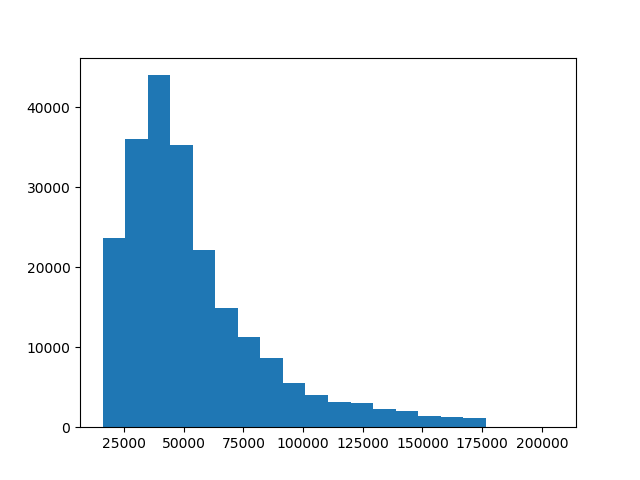

(array([2.3605e+04, 3.6066e+04, 4.3977e+04, 3.5225e+04, 2.2094e+04,
        1.4909e+04, 1.1218e+04, 8.5860e+03, 5.5530e+03, 4.0800e+03,
        3.1770e+03, 2.9940e+03, 2.2190e+03, 1.9730e+03, 1.4400e+03,
        1.3240e+03, 1.2110e+03, 0.0000e+00, 0.0000e+00, 8.0000e+00]),
 array([ 16000.   ,  25443.056,  34886.112,  44329.168,  53772.224,
         63215.28 ,  72658.336,  82101.392,  91544.448, 100987.504,
        110430.56 , 119873.616, 129316.672, 138759.728, 148202.784,
        157645.84 , 167088.896, 176531.952, 185975.008, 195418.064,
        204861.12 ]),
 <a list of 20 Patch objects>)

In [70]:
fig, ax = plt.subplots(1, 1)
ax.hist(mod_frame.annual_salary, bins=20)